In [1]:
from sklearn.pipeline import Pipeline
from patsy import dmatrices
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV,ShuffleSplit, train_test_split
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
%matplotlib inline
pd.set_option('display.max_columns', None) 
pd.set_option("display.max_rows",100)

36 months loans number Paid Off: 424574
36 months loans number Charged Off: 82236
36 months Loans Default Percentage: 16.23%

60 months loans number Paid Off: 106478
60 months loans number Charged Off: 52268
60 months Loans Default Percentage: 32.93%

Overall loans number Paid Off: 531052
Overall loans number Charged Off: 134504
Overall Loans Default Percentage: 20.21%


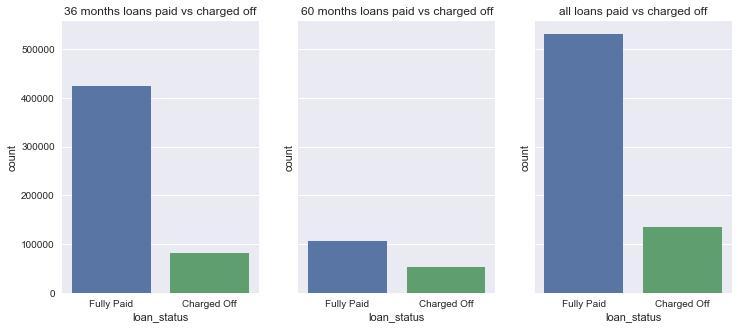

In [2]:
temp = pd.read_pickle('/Users/pwu/dsi-plus/capstone/docker/postgres/data/cleaned_rows_lending_club_v2.pkl')

#Check Total Default Rate, 36 months default rate, 60 months default rate
cf36_mask = (temp['loan_status']=='Charged Off') & (temp['term']==36 )
cf60_mask = (temp['loan_status']=='Charged Off') & (temp['term']==60)
fp36_mask = (temp['loan_status']=='Fully Paid') & (temp['term']==36 )
fp60_mask = (temp['loan_status']=='Fully Paid') & (temp['term']==60 )
mask36 = temp['term'] == 36
mask60 = temp['term'] == 60
#sns.countplot(x = 'loan_status',data = temp[mask36], ax = axes[0] )
#plt.rcParams['figure.figsize']=(3,3)
fig, axes = plt.subplots(1,3, figsize=(12,5),sharey = True)
sns.countplot(x = 'loan_status',data = temp[mask36] , ax = axes[0], order =['Fully Paid', 'Charged Off'])
axes[0].set(title = '36 months loans paid vs charged off')
sns.countplot(x = 'loan_status',data = temp[~mask36], ax = axes[1], order =['Fully Paid', 'Charged Off'])
axes[1].set(title = '60 months loans paid vs charged off')
sns.countplot(x = 'loan_status', data = temp, ax = axes[2], order =['Fully Paid', 'Charged Off'])
axes[2].set(title = 'all loans paid vs charged off')
#plt.xlabel('Loan Status')
print('36 months loans number Paid Off: {}'.format(temp[fp36_mask].shape[0]))
print('36 months loans number Charged Off: {}'.format(temp[cf36_mask].shape[0]))
default_rate = (np.float64(temp[cf36_mask].shape[0]) / np.float64(temp[mask36].shape[0])*100).round(2)
print('36 months Loans Default Percentage: {}%\n'.format(default_rate))

print('60 months loans number Paid Off: {}'.format(temp[fp60_mask].shape[0]))
print('60 months loans number Charged Off: {}'.format(temp[cf60_mask].shape[0]))
default_rate = (np.float64(temp[cf60_mask].shape[0]) / np.float64(temp[mask60].shape[0])*100).round(2)
print('60 months Loans Default Percentage: {}%\n'.format(default_rate))

print('Overall loans number Paid Off: {}'.format(temp[temp['loan_status']=='Fully Paid'].shape[0]))
print('Overall loans number Charged Off: {}'.format(temp[temp['loan_status']=='Charged Off'].shape[0]))
default_rate = (np.float64(temp[temp['loan_status']=='Charged Off'].shape[0]) / np.float64(temp.shape[0])*100).round(2)
print('Overall Loans Default Percentage: {}%'.format(default_rate))


In [3]:
df = pd.read_pickle('/Users/pwu/dsi-plus/capstone/docker/postgres/data/all_clean_lending_club_v2.pkl')

In [ ]:
mask = df['term'] == 60

In [4]:
df.groupby(['term'])['int_rate'].mean()

term
36    0.124561
60    0.170265
Name: int_rate, dtype: float64

In [5]:
mask = df['term'] == 60
long_loan= pd.DataFrame(df[mask])

In [6]:
#split 60 month loan into Grade A,B(high) and C-G(low)
mask = (long_loan['grade']== 'A') | (long_loan['grade'] =='B') 
long_high = pd.DataFrame(long_loan[mask])
long_low = pd.DataFrame(long_loan[~mask])

In [9]:
#60 month loan mean interest rate by loan grade
tep = pd.DataFrame(long_loan.groupby(['grade'])['int_rate'].describe())
tep.reset_index(inplace = True)
tep.drop(['std', 'min','25%','50%','75%', 'max'], axis = 1, inplace = True)
tep.columns= ['Loan_Grade', 'Number_Of_Loans', 'Mean_Interest_Rate']
tep['Mean_Interest_Rate'] = ((tep['Mean_Interest_Rate']*100).round(2)).astype(str) + '%'
tep

,Loan_Grade,Number_Of_Loans,Mean_Interest_Rate
0,A,2615.0,7.99%
1,B,20460.0,10.91%
2,C,45943.0,14.35%
3,D,37521.0,17.49%
4,E,33024.0,20.41%
5,F,14905.0,23.95%
6,G,4278.0,26.26%


In [10]:
mask1 = long_loan['loan_status'] == 'Charged Off'
tep2 = pd.DataFrame(long_loan[mask1]['grade'].value_counts()/long_loan['grade'].value_counts())
#long_loan[mask].groupby(['grade']).count()
tep2.reset_index(inplace = True)
tep2.columns = ['Loan_Grade','Default_Percentage']
tep2['Default_Percentage'] = (tep2['Default_Percentage']* 100).round(2).astype(str) + '%'


In [11]:
#60 month loan default rate by Loan Grade
tep2.sort_values(['Loan_Grade'], ascending = True)

,Loan_Grade,Default_Percentage
0,A,9.48%
1,B,17.83%
2,C,26.74%
3,D,35.98%
4,E,41.36%
5,F,45.93%
6,G,48.64%


In [12]:
default_rate_high = (np.float64(long_high[long_high['loan_status']=='Charged Off'].shape[0]) / np.float64(long_high.shape[0])*100).round(2)
print('high quality Overall Loans Default Percentage: {}%'.format(default_rate_high))
default_rate = (np.float64(long_low[long_low['loan_status']=='Charged Off'].shape[0]) / np.float64(long_low.shape[0])*100).round(2)
print('low quality Overall Loans Default Percentage: {}%'.format(default_rate))


high quality Overall Loans Default Percentage: 16.88%
low quality Overall Loans Default Percentage: 35.65%


In [14]:
#change earliest credit line from date to number of days before the issue date of the loan
long_low['cr_line_days']=(long_low['issue_d'] - long_low['earliest_cr_line'])
long_low['cr_line_days'] = long_low['cr_line_days'].dt.days.astype(int)

In [15]:
#take the mean of the fico range 
long_low['fico_mean'] = (long_low['fico_range_high'] + long_low['fico_range_low'])/2

In [ ]:
#long_low.drop(['fico_range_high', 'fico_range_low'], axis = 1, inplace = True)

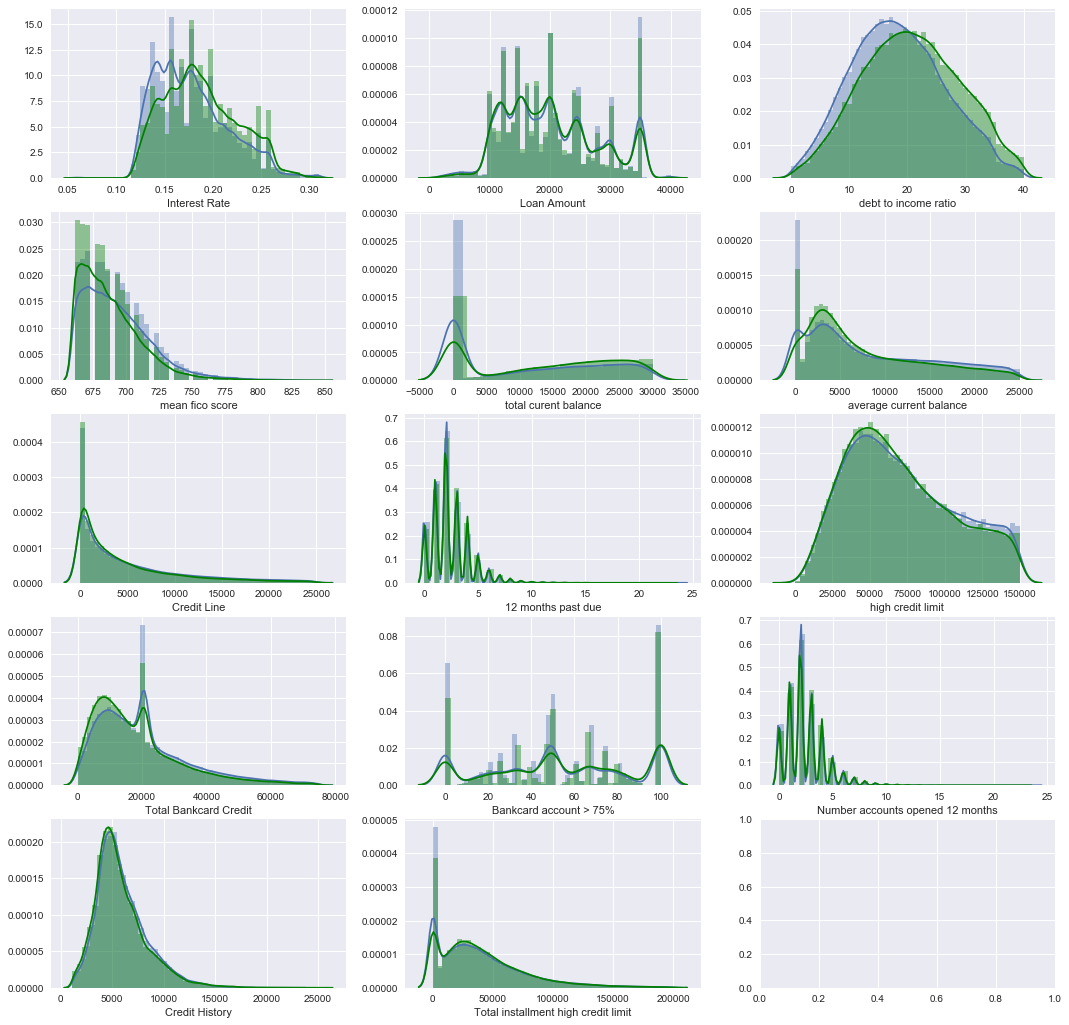

In [16]:
mask = (long_low['loan_status']=='Fully Paid') 
mask1 = (long_low['loan_status']=='Fully Paid') & (long_low['tot_cur_bal'] <= 30000)
mask2 = (long_low['loan_status']=='Charged Off') & (long_low['tot_cur_bal'] <= 30000)
fig, axes = plt.subplots(5,3, figsize=(18,18))
sns.distplot( long_low[mask]['int_rate'] , ax = axes[0,0])
sns.distplot( long_low[~mask]['int_rate'] , ax = axes[0,0], color = 'green')
axes[0,0].set( xlabel='Interest Rate')
sns.distplot( long_low[mask]['loan_amnt'], ax = axes[0,1])
sns.distplot( long_low[~mask]['loan_amnt'], ax = axes[0,1], color='green')
axes[0,1].set( xlabel='Loan Amount')
sns.distplot( long_low[mask]['dti'], ax = axes[0,2])
sns.distplot( long_low[~mask]['dti'], ax = axes[0,2], color = 'green')
axes[0,2].set( xlabel='debt to income ratio')

sns.distplot( long_low[mask]['fico_mean'] , ax = axes[1,0])
sns.distplot( long_low[~mask]['fico_mean'] , ax = axes[1,0], color = 'green')
axes[1,0].set( xlabel='mean fico score')
sns.distplot( long_low[mask1]['tot_cur_bal'], ax = axes[1,1])
sns.distplot( long_low[mask2]['tot_cur_bal'], ax = axes[1,1], color = 'green')
axes[1,1].set( xlabel='total curent balance')
mask1 = (long_low['loan_status']=='Fully Paid') & (long_low['avg_cur_bal'] <= 25000)
mask2 = (long_low['loan_status']=='Charged Off') & (long_low['avg_cur_bal'] <= 25000)
sns.distplot( long_low[mask1]['avg_cur_bal'], ax = axes[1,2])
sns.distplot( long_low[mask2]['avg_cur_bal'], ax = axes[1,2], color = 'green')
axes[1,2].set( xlabel='average current balance')

mask1 = (long_low['loan_status']=='Fully Paid') & (long_low['bc_open_to_buy'] <= 25000)
mask2 = (long_low['loan_status']=='Charged Off') & (long_low['bc_open_to_buy'] <= 25000)
sns.distplot( long_low[mask1]['bc_open_to_buy'] , ax = axes[2,0])
sns.distplot( long_low[mask2]['bc_open_to_buy'] , ax = axes[2,0], color = 'green')
axes[2,0].set( xlabel='Credit Line')
sns.distplot( long_low[mask]['num_tl_op_past_12m'], ax = axes[2,1])
sns.distplot( long_low[~mask]['num_tl_op_past_12m'], ax = axes[2,1], color = 'green')
axes[2,1].set( xlabel='12 months past due')
mask1 = (long_low['loan_status']=='Fully Paid') & (long_low['tot_hi_cred_lim'] <= 150000)
mask2 = (long_low['loan_status']=='Charged Off') & (long_low['tot_hi_cred_lim'] <= 150000)
sns.distplot( long_low[mask1]['tot_hi_cred_lim'], ax = axes[2,2])
sns.distplot( long_low[mask2]['tot_hi_cred_lim'], ax = axes[2,2], color = 'green')
axes[2,2].set( xlabel='high credit limit')

mask1 = (long_low['loan_status']=='Fully Paid') & (long_low['total_bc_limit'] <= 75000)
mask2 = (long_low['loan_status']=='Charged Off') & (long_low['total_bc_limit'] <= 75000)
sns.distplot( long_low[mask1]['total_bc_limit'] , ax = axes[3,0])
sns.distplot( long_low[mask2]['total_bc_limit'] , ax = axes[3,0], color = 'green')
axes[3,0].set( xlabel='Total Bankcard Credit')
sns.distplot( long_low[mask]['percent_bc_gt_75'], ax = axes[3,1])
sns.distplot( long_low[~mask]['percent_bc_gt_75'], ax = axes[3,1], color = 'green')
axes[3,1].set( xlabel='Bankcard account > 75%')
sns.distplot( long_low[mask]['num_tl_op_past_12m'], ax = axes[3,2])
sns.distplot( long_low[~mask]['num_tl_op_past_12m'], ax = axes[3,2], color = 'green')
axes[3,2].set( xlabel='Number accounts opened 12 months')

mask1 = (long_low['loan_status']=='Fully Paid') 
mask2 = (long_low['loan_status']=='Charged Off')
sns.distplot( long_low[mask1]['cr_line_days'] , ax = axes[4,0])
sns.distplot( long_low[mask2]['cr_line_days'] , ax = axes[4,0], color = 'green')
axes[4,0].set( xlabel='Credit History')

mask1 = (long_low['loan_status']=='Fully Paid') & (long_low['total_il_high_credit_limit'] <=  200000)
mask2 = (long_low['loan_status']=='Charged Off') & (long_low['total_il_high_credit_limit'] <= 200000)
sns.distplot( long_low[mask1]['total_il_high_credit_limit'], ax = axes[4,1])
sns.distplot( long_low[mask2]['total_il_high_credit_limit'], ax = axes[4,1], color = 'green')
axes[4,1].set( xlabel='Total installment high credit limit')
#sns.distplot( long_low[mask]['num_tl_op_past_12m'], ax = axes[4,2])
#sns.distplot( long_low[~mask]['num_tl_op_past_12m'], ax = axes[4,2], color = 'green')
#axes[4,2].set( xlabel='Number accounts opened 12 months')

#### Plot the Charge Off Rate for 60 month loans by State

In [17]:
loan_state_df = pd.DataFrame(long_low[['addr_state','loan_status']])
loan_state_df_corr = pd.get_dummies(loan_state_df, columns = ['addr_state','loan_status'])

#group number of charge offs by state
temp = pd.get_dummies(loan_state_df, columns = ['loan_status'])
charge_off_by_state = pd.DataFrame(temp.groupby(['addr_state']).sum().sort_values(['loan_status_Charged Off'], ascending = False))
charge_off_by_state['Total_Loans'] = charge_off_by_state['loan_status_Charged Off'] + charge_off_by_state['loan_status_Fully Paid']
charge_off_by_state['charge_off_rate']= charge_off_by_state['loan_status_Charged Off']  / charge_off_by_state['loan_status_Fully Paid']

charge_off_by_state.reset_index(inplace = True)
charge_off_by_state.sort_values(['charge_off_rate'], ascending = False)
charge_off_by_state.columns = ['State', 'Charged_Off', 'Fully_Paid', 'Total_Loans', 'Charge_Off_Rate']
#charge_off_by_state

In [18]:
import plotly.plotly as py
import plotly
import pandas as pd
plotly.offline.init_notebook_mode(connected=True)
#charge_off_by_state

for col in charge_off_by_state.columns:
    charge_off_by_state[col] = charge_off_by_state[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

charge_off_by_state['text'] = charge_off_by_state['State'] + '<br>' +\
    'Total Loans '+charge_off_by_state['Total_Loans']+'<br>'+\
    'Fully Paid '+charge_off_by_state['Fully_Paid']+'<br>'+\
    'Charged Off '+charge_off_by_state['Charged_Off']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = charge_off_by_state['State'],
        z = (charge_off_by_state['Charge_Off_Rate'].astype(float)).round(4) ,
        locationmode = 'USA-states',
        text = charge_off_by_state['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Charge Off Rate")
        ) ]

layout = dict(
        title = '60 month loan Charge Off Rate by State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, filename='d3-cloropleth-map' )


In [19]:
#drop columns not used in model
long_low.drop(['term','issue_year','grade','installment','emp_title', 'issue_d','title','earliest_cr_line', 'fico_range_low', 'fico_range_high'], axis = 1, inplace = True)

In [20]:
#get dummies
long_term_low_qual = pd.get_dummies(long_low, columns = ['sub_grade','emp_length','home_ownership','verification_status', 'loan_status','purpose', 'addr_state'])

In [21]:
#set the target variable
y = long_term_low_qual['loan_status_Fully Paid']

In [22]:
#drop target variable from dataframe
long_term_low_qual.drop(['loan_status_Fully Paid', 'loan_status_Charged Off'], axis = 1, inplace = True)

In [23]:
#quick look at the data 
long_term_low_qual.head(2)

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,cr_line_days,fico_mean,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_n/a,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
1,2500.0,0.1527,30000.0,1.00,0.0,5.0,3.0,0.0,1687.0,0.094,4.0,0.0,0.0,0.0,0.0,0.0,4.685103,0.0,0.0,61.956015,0.0,0.0,125.761258,180.290193,12.658652,7.690894,0.0,23.363396,7.0,0.0,4.0,6.0,5.0,9.0,9.0,8.0,15.0,6.0,12.0,0.0,0.0,0.0,2.0,94.0,48.0,0.0,0.0,171681.0,48000.0,20627.0,0.0,4627,742.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,7000.0,0.1596,47004.0,23.51,0.0,1.0,7.0,0.0,17726.0,0.856,11.0,0.0,0.0,0.0,0.0,0.0,4.685103,0.0,0.0,61.956015,0.0,0.0,125.761258,180.290193,12.658652,7.690894,0.0,23.363396,7.0,0.0,4.0,6.0,5.0,9.0,9.0,8.0,15.0,6.0,12.0,0.0,0.0,0.0,2.0,94.0,48.0,0.0,0.0,171681.0,48000.0,20627.0,0.0,2344,692.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
#train test split dataset
X_train, X_test, y_train, y_test = train_test_split(long_term_low_qual, y, stratify = y, test_size=0.3, random_state=42)

In [25]:
#Create  pipeline
pipe = Pipeline([
    ('skb', SelectKBest(score_func=f_classif)),
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(ElasticNet())),
    ('gbc', AdaBoostClassifier())
])
#Create parameters list
params = {
    'skb__k':[100,125],
    'sfm__estimator':[ElasticNet(alpha,l1_ratio)  for alpha in [3,5] for l1_ratio in [.1,.3]],
    'gbc__learning_rate':[1],
    'gbc__n_estimators':[100,200,250] 
}
#grid search
gs = GridSearchCV(pipe,
                      params,
                      cv=ShuffleSplit(n_splits=3, random_state=42), 
                      n_jobs= -1
                     )


In [26]:
model = gs.fit(X_train, y_train)

In [27]:
model.best_params_

{'gbc__learning_rate': 1,
 'gbc__n_estimators': 250,
 'sfm__estimator': ElasticNet(alpha=3, copy_X=True, fit_intercept=True, l1_ratio=0.1,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 'skb__k': 125}

In [28]:
model.best_estimator_

Pipeline(steps=[('skb', SelectKBest(k=125, score_func=<function f_classif at 0x11a06ae18>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=ElasticNet(alpha=3, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positiv...hm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=250, random_state=None))])

In [29]:
y_pred = model.predict(X_test)

In [37]:
model.score(X_train, y_train)

0.6740094135981215

In [30]:
 tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(3900, 10612, 3026, 23164)

In [31]:
recall = tp/(tp+fn)
precision = tp/(tp+fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
specificity = tn/(tn+fp)
print('specificity: {}'.format(specificity.round(4)))
print('accuracy: {}'.format(accuracy.round(4)))
print('precision: {}'.format(precision.round(4)))
print('recall/sensitivity: {}'.format(recall.round(4)))

specificity: 0.2687
accuracy: 0.6649
precision: 0.6858
recall/sensitivity: 0.8845


In [36]:
result_df = pd.DataFrame(list(zip(X_test.columns,model.best_estimator_.named_steps['gbc'].feature_importances_)))
result_df.columns = ['Feature_Name', 'Feature_Importance']
result_df.sort_values(['Feature_Importance'], ascending = False).head(10)

,Feature_Name,Feature_Importance
1,int_rate,0.076
3,dti,0.064
42,num_tl_op_past_12m,0.040
0,loan_amnt,0.036
2,annual_inc,0.036
13,tot_coll_amt,0.028
17,avg_cur_bal,0.028
46,tax_liens,0.024
47,tot_hi_cred_lim,0.024
24,mo_sin_rcnt_rev_tl_op,0.024
